# Prepare and export stream files with `f3ast`

This notebook aims to give an overview of possible functionalities of the `f3ast` package, with probably only parts of it relevant to your specific structure/problem. Mix and match to your heart's delight :-)

## Import packages and define microscope settings

In [3]:
import sys
sys.path.append(r"C:/Users/bgh19/OneDrive/Coding/GithubRepos/f3ast")
import f3ast
import numpy as np
import matplotlib.pyplot as plt
import trimesh.grouping as tg



ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [2]:
# settings can be loaded from a specified json file (given by file_path="...")
# settings = f3ast.load_settings()

# or settings can be defined manually in a dictionary:
settings = {}
settings["structure"] = {"pitch": 3, "fill": False}  # in nm
settings["stream_builder"] = {
    "addressable_pixels": [65536, 56576],
    "max_dwt": 5,  # in ms
    "cutoff_time": 0.01,  # in ms, for faster exporting: remove dwells below cutoff time
    "screen_width": 10.2e3,  # in nm, horizontal screen width / field of view
    # 'serpentine' or 'serial', scanning order between slices
    "scanning_order": "serpentine",
}
# pixel size for thermal resistance
settings["dd_model"] = {"single_pixel_width": 50}

## Import and modify `stl` structure

In [3]:
file_path = "3x3x3-singlegyroid-64res-level1.stl"
struct = f3ast.Structure.from_file(file_path, **settings["structure"])

# rotate: specify axis and angle in degrees
# this is for example useful if FEBID growth is done with a tilted SEM sample stage
rotation_axis, rotation_angle = (0, 0, 0), (30)
struct.rotate(rotation_axis, rotation_angle)

# In some cases (e.g. Helios 600) , stream files appear mirrored on the SEM screen
# compared to the orientation of the initial stl structure.
# If precise orientation of the structure (e.g. with respect to the GIS) is important,
# a mirror operation can be applied across a plane with a given normal.
# struct.mirror(normal=(0, 0, 0))

struct.centre()  # centers xy to zero and sets minimum z value to zero
struct.rescale(50)  # scale the structure 3x

# interactive plot for inspection
struct.show()

## Define the growth model

For the two main growth models - RRL (reaction-rate limited growth) with constant dwell time in height, and DD (desorption-dominated growth), for which the dwell time are modified taking into account increasing thermal resistance with structure length and height.

In [4]:
GR0 = 0.200 # in um/s, base growth rate
k = 1.25 # in 1/nm?, thermal conductivity 
sigma = 4 # in nm, dwell size

# simple model, without thermal correction
# %time model = f3ast.RRLModel(struct, GR0, sigma)

# with correction due to thermal conductivity
%time model = f3ast.DDModel(struct, GR0, k, sigma, **settings['dd_model'])

Slicing...
Sliced
CPU times: total: 36.9 s
Wall time: 27.5 s


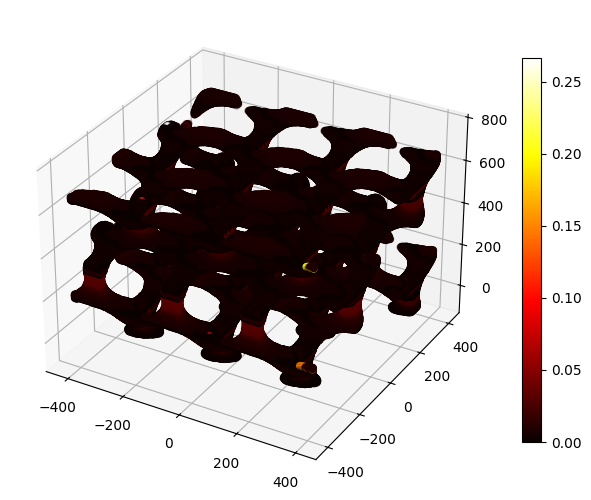

In [16]:
# plot thermal resistance for a check
# if there are discontinuities a z-dependent model for the dwell time might be better (see below)

ax = struct.plot_slices(c=np.concatenate(model.resistance), cmap="hot")

## Solve for dwells and inspect

Solving for dwells...
Solved
CPU times: total: 1.8 s
Wall time: 1min 52s
Total stream time:  0:17:41.880908


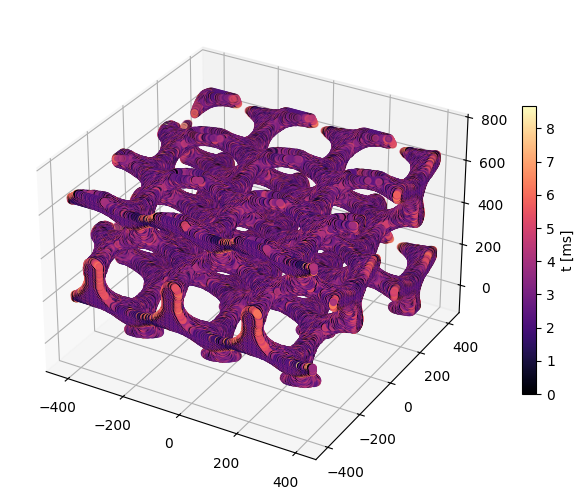

In [5]:
%time stream_builder, dwell_solver = f3ast.StreamBuilder.from_model(model, **settings['stream_builder'])


dwell_solver.print_total_time()

# inspect dwells 
ax, sc = dwell_solver.show_solution()

In [51]:
intersection_lines, zlev = struct.get_intersection_lines()



In [ ]:
# print(np.asarray(intersection[0]))


# inter_slices = [inter.reshape(-1,2) for inter in intersection]
# np.set_printoptions(threshold=sys.maxsize)
intersection = [inter for inter in intersection_lines if len(inter) != 0]
n = intersection[10]
reshaped_inter = n.reshape(-1,2)
print(reshaped_inter)
groups = tg.group_rows(reshaped_inter)
print

The solver process for f3ast goes like this:

1. f3ast loads the STL file and creates a Trimesh object from it.
    > struct = f3ast.Structure.from_file(file_path, **settings["structure"])

2. The Structure module slices the trimesh object and obtains lines that approximate the surface at each layer. This is done using trimesh's mesh_multiplane. The resulting data is made up of a ton of lines at each z height.

3. The split_intersection function is called from branches module, which uses the trimesh grouping to find 

2. The deposit_model module 
    > model = f3ast.DDModel(struct, GR0, k, sigma, **settings['dd_model'])  

3. Stream_builder module creates StreamBuilder class with the from_model function.  This initializes by calling DwellSolver, from the solver module.
    > stream_builder, dwell_solver = f3ast.StreamBuilder.from_model(model, **settings['stream_builder'])

4. 
    

In [ ]:

dwell_layers = dwell_solver.get_dwells_slices()
### Get dwells by layer. dwell_layers is a list of length n_layers, with each entry being a numpy array of shape (NumPoints, 4). Each point is associated with x,y,z,dwell.


for n in dwell_layers[::200]:
    dwell_slice = np.asarray(n)
    positions = dwell_slice[:, 1:3]
    print(positions.shape)
    print(positions)

(857, 2)
[[-417.  252.]
 [-417.  255.]
 [-417.  258.]
 ...
 [ 408.  285.]
 [ 408.  288.]
 [ 408.  291.]]
(488, 2)
[[-369. -390.]
 [-369. -387.]
 [-369. -384.]
 [-369. -381.]
 [-366. -390.]
 [-366. -378.]
 [-363. -375.]
 [-363. -372.]
 [-360. -390.]
 [-360. -369.]
 [-357. -390.]
 [-357. -369.]
 [-357. -366.]
 [-354. -390.]
 [-354. -366.]
 [-351. -390.]
 [-351. -366.]
 [-351. -363.]
 [-348. -363.]
 [-345. -390.]
 [-345. -366.]
 [-342. -390.]
 [-342. -366.]
 [-339. -390.]
 [-339. -369.]
 [-336. -390.]
 [-336. -369.]
 [-333. -372.]
 [-330. -390.]
 [-330. -384.]
 [-330. -381.]
 [-330. -378.]
 [-330. -375.]
 [-327. -390.]
 [-327. -384.]
 [-369.  381.]
 [-369.  384.]
 [-369.  387.]
 [-369.  390.]
 [-369.  393.]
 [-366.  378.]
 [-366.  381.]
 [-366.  393.]
 [-363.  375.]
 [-363.  378.]
 [-363.  393.]
 [-360.  372.]
 [-360.  393.]
 [-357.  372.]
 [-357.  393.]
 [-354.  369.]
 [-354.  393.]
 [-351.  369.]
 [-351.  393.]
 [-348.  369.]
 [-348.  393.]
 [-345.  372.]
 [-345.  393.]
 [-342.  372.]
 

## Export stream files

Depending on the interface of the SEM/dual beam you are working with, the visible name of the stream file might be very short (e.g., 18 characters only for the Helios 600). In this case, it makes sense to keep a short filename, and/or put the most important pieces of information of the pattern into the beginning.

It can be helpful to also add the total writing time for an exported stream at the end, see example below how to create a descriptive filename from patterning parameters.

In [33]:
# get stream
strm = stream_builder.get_stream()

# export with simple name
out_filename = "IWP_model_v3_200gr_3k_4sig_p3"
strm.write(f"{out_filename}.str")

# this is an example on how to build a descriptive filename
# e.g. with growth rate GR0 in nm/s, and total writing time in seconds
# total_time = f"{strm.get_time().seconds}.{strm.get_time().microseconds/1e5:.0f}s"
# out_filename = f"stream_test-GR{GR0*1e3:.0f}-{total_time}"
print(out_filename)

IWP_model_v3_200gr_3k_4sig_p3


In [8]:
# the stream can be loaded back if the stream_builder object is still defined:
# strm.from_file(f'{save_path}.str')

## Save models

`f3ast` also allows to save a stream builder object for later use. This is particularly useful for large structures to be treated with the DDModel, as the calculation of thermal correction/connectivity scales non-linearly with the size of the bounding box of the structure.

In [9]:
# save
save_path = "stream_test"
f3ast.save_build(save_path, dwell_solver, stream_builder)

# retrieve
load_path = f"{save_path}.pickle"
dwell_solver, stream_builder = f3ast.load_build(load_path)

## Exponential dwell time correction in $z$

Sometimes the DDModel does not work well, e.g., if the stl structure has disconnected segments -- in this case the above plot of the thermal resistance would feature discontinuities in $z$. For this case, the following model, based on doubling of the dwell time with height, can give better growth results.

The correct doubling length needs to be determined experimentally, e.g., by tracking how the pitch of a nominally periodic structure varies with growth height.

In [38]:
from f3ast.deposit_model import HeightCorrectionModel

# settings are mandatory to be defined
GR0 = 0.200 # in um/s, base growth rate (at bottom)
doubling_length = 1000. # innm, doubling length of dwell time
sigma = 4 # in nm, deposit size
model = HeightCorrectionModel(struct, GR0, sigma, doubling_length)

%time stream_builder, dwell_solver = f3ast.StreamBuilder.from_model(model, **settings['stream_builder'])
dwell_solver.print_total_time()

# inspect dwells 
ax, sc = dwell_solver.show_solution()
# export and inspection is the same as for the examples above

ImportError: cannot import name 'HeightCorrectionModel' from 'f3ast.deposit_model' (C:\Users\same2\anaconda3\envs\FEBID-240430\Lib\site-packages\f3ast\deposit_model.py)